In [1]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=4942811895b5d44609799d411990fee418841234f00b74c8a8095fbc26d510cd
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


# **Solving the XOR problem using a single quantum perceptron.**

In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
theta = np.pi
alpha = -np.pi/2

In [3]:
x_input = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_input = np.array([[0], [1], [1], [0]])

Here is the circuit we gonna use to solve the XOR problem.
The circuit is combined of a hadamard gate a Rz gate and a Rx gate

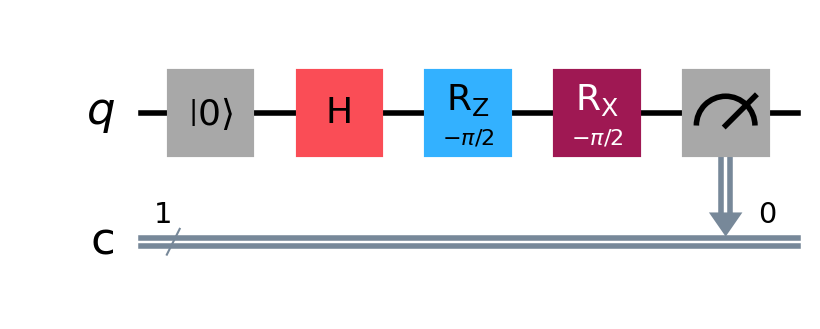

In [4]:
quantum_circuit = QuantumCircuit(1, 1)
quantum_circuit.reset(0)
quantum_circuit.h(0)
quantum_circuit.rz(x_input[0][0]*theta + alpha, 0)
quantum_circuit.rx(x_input[0][1]*theta + alpha, 0)
quantum_circuit.measure(0, 0)
quantum_circuit.draw(output='mpl', scale=2, style='iqx')

In [5]:
for x in x_input:
  quantum_circuit = QuantumCircuit(1, 1)
  quantum_circuit.reset(0)
  quantum_circuit.h(0)
  quantum_circuit.rz(x[0]*theta + alpha, 0)
  quantum_circuit.rx(x[1]*theta + alpha, 0)
  quantum_circuit.measure(0, 0)
  simulator = Aer.get_backend('aer_simulator')
  job = simulator.run(quantum_circuit, shots=1024)
  results = job.result()
  counts = results.get_counts()
  max_key = max(counts, key=lambda k: counts[k])
  prediction = int(max_key)
  print(f'{x[0]} xor {x[1]} = {prediction}')


0 xor 0 = 0
0 xor 1 = 1
1 xor 0 = 1
1 xor 1 = 0


# **Training a quantum perceptron to solve the XOR problem**

After proving that we can solve the xor problem using a single quantum perceptron, now we prove that we can train it to solve the XOR problem.

The quantum_perceptron function is equivelent to a forward pass in the classical MLP it simulates a quantum circuit with input paramaters then is return the value of the qubit with the highest probability of accuring after measurement.

In [6]:
def quantum_perceptron(qc, input_data, weights, bias):
    qc.reset(0)
    qc.h(0)
    qc.rz(input_data[0]*weights[0]+bias[0], 0)
    qc.rx(input_data[1]*weights[1]+bias[0], 0)
    qc.measure(0, 0)
    simulator = Aer.get_backend('aer_simulator')
    job = simulator.run(qc, shots=1024)
    results = job.result()
    counts = results.get_counts()
    max_key = max(counts, key=lambda k: counts[k])


    prediction = int(max_key)

    return prediction

In [7]:
objective_func_vals = []

def callback_graph(obj_func_eval):
  clear_output(wait=True)
  objective_func_vals.append(obj_func_eval)
  plt.title("Objective function value against iteration")
  plt.xlabel("Iteration")
  plt.ylabel("Objective function value")
  plt.plot(range(len(objective_func_vals)), objective_func_vals)
  plt.show()

In [8]:
def calculate_loss(target, prediction):
    return np.mean(np.abs(target - prediction))

The update_weights update the weights based on a simple rule:

$w := w + \eta (real  value - predictedvalue) * x$

In [9]:
def update_weights(weights, l_rate, target, prediction, feature):
    new_weights = []
    for x, w in zip(feature, weights):
        new_w = w + l_rate*(target - prediction)*x
        new_weights.append(new_w[0])
    """This line is to solve the ircuitError:
     "Invalid param type <class 'numpy.ndarray'> for gate rz." problem."""
    new_weights = np.array(new_weights)
    return new_weights

The same thing with update_bias except we do not multiply the loss with the features:

$b := b + \eta (real  value - predictedvalue)$

In [10]:
def update_bias(bias, l_rate, target, prediction):
    return bias + l_rate*(target - prediction)

We initialize the weights and the bias

In [11]:
random_weights = np.random.uniform(-4, 4, 2)

In [12]:
bias = np.random.uniform(-4, 4, 1)

Now we train our quantum perceptron with learning rate of 0.1 and 30 epochs.

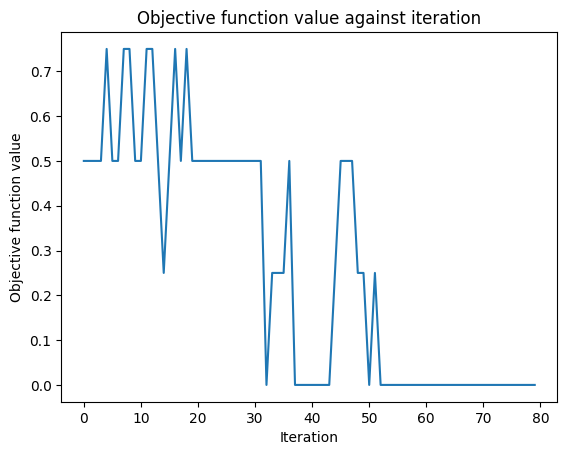

In [13]:
l_rate = 0.1
epochs = 80
objective_func_vals = []
for _ in range(epochs):
#     print(f'Epoch {_ + 1}')
    i = 0
    targets = []
    preds = []
    for data in x_input:
        qc=QuantumCircuit(1, 1)
        prediction = quantum_perceptron(qc, data, random_weights, bias)
        preds.append(prediction)
        targets.append(np.array(y_input[i]))
        if prediction != y_input[i]:

            random_weights = update_weights(random_weights, l_rate, y_input[i], prediction, data)
            bias = update_bias(bias, l_rate, y_input[i], prediction)

        i += 1

    preds = np.array(preds)
    targets = np.array(targets)
    targets = targets.flatten()
    loss = calculate_loss(target=targets, prediction=preds)
    callback_graph(loss)

    

Now we test our quantum_perceptron to see if it learned.

In [14]:
i = 0
for x in x_input:
  qc = QuantumCircuit(1, 1)
  prediction = quantum_perceptron(qc, x, random_weights, bias)
  print(f'{x[0]} xor {x[1]} = {prediction}')
  i+=1

0 xor 0 = 0
0 xor 1 = 1
1 xor 0 = 1
1 xor 1 = 0


We proved that we can solve a linearly inseparable problem using only one quantum perceptron, unlike the classical MLP that needs at least two perceptrons to solve the XOR problem.

# **Conclusion**

A quantum perceptron has the ability to solve a problem that is linearly inseparable due to the proprties of the Hilbert space.